In [64]:
import torch
import torch.nn as nn
import torch.optim as optim


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import read_table

from sklearn.metrics import mean_squared_error, accuracy_score

from torch.nn.utils.rnn import pad_sequence

import torch.optim.lr_scheduler as lr_scheduler


In this one, I try to predict 2 things using RNNs on player stats: Classification on whether the NextYearOPS will increase or not, and Regression on the next year's OPS score. Could be interesting to replace NextYearOPS to NextYearOPS diff

In [65]:
# sequence length dictates how many years into the past we will look in order to predict the next value.
sequence_length = 4
test_ratio = 0.2

In [66]:
# Define the RNN model
class RNN_regresser(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN_regresser, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) 
        return out
    
# Define the RNN model
class RNN_classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN_classifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) 
        return self.sig(out)


In [67]:
def find_cutoff_index(playerIDlist, test_ratio):
    # returns a correct index for cutting off training and test data, must include the index in training data
    if not (test_ratio < 1 and test_ratio > 0): return Exception("Fuck you")
    approx_index = int(len(playerIDlist) * (1 - test_ratio))
    approx_index_is_correct = playerIDlist[approx_index] != playerIDlist[approx_index + 1]
    while not approx_index_is_correct:
        approx_index += 1
        approx_index_is_correct = playerIDlist[approx_index] != playerIDlist[approx_index + 1]
    return approx_index + 1

def pd_to_tensor(df):
    return torch.tensor(np.array(df)).float()

def normalize_X(X):
    mean = X.mean(dim=0)
    std = X.std(dim=0)
    return (X - mean) / std


In [68]:
from sklearn.preprocessing import StandardScaler

def mark_invalid_nextYearOPS(nextYearOPS, players):
    # gives a null value to all values in NextYearOPS that correspond to a playerID's last year
    null_value = np.nan
    nextYearOPS.iloc[len(players) - 1] = null_value

    for i in range(len(players) - 1):
        if players[i] != players[i+1]:
            nextYearOPS.iloc[i] = null_value
    
    return nextYearOPS

def get_OPS_series(df_bat):
    # low level stats not in the dataset
    pa = df_bat["AB"] + df_bat["BB"] + df_bat["IBB"] + df_bat["HBP"] # player appearance
    oneB = df_bat["H"] - df_bat["2B"] - df_bat["3B"] - df_bat["HR"] # first base hits
    # high level stats to calculate
    OnBaseP = (df_bat["BB"] + df_bat["IBB"] + df_bat["HBP"] + df_bat["H"]) / pa
    Slugging = (oneB + 2*df_bat["2B"] + 3*df_bat["3B"] + 4*df_bat["HR"]) / df_bat["AB"]
    # OPS
    ops = OnBaseP + Slugging
    
    return ops.fillna(0)

def get_NextYearOPS_series(df):
    # When NextYearOPS can't be given because there is no next year, np.nan is assigned
    # Realistically, 
    ops = get_OPS_series(df)
    nextYearOPS = ops.shift(-1)
    nextYearOPS = mark_invalid_nextYearOPS(nextYearOPS, df["playerID"])
    return nextYearOPS


def get_OPSWillIncrease_series(df):
    ops = get_OPS_series(df)
    nextYearOPS = get_NextYearOPS_series(df)
    return ops < nextYearOPS

def remove_NextYearOPS_invalid_rows(df):
    # assumes df[NextYearOPS] exists
    df = df.dropna(subset=['NextYearOPS'])
    df = df.reset_index().drop(columns=['index'])

    return df

def split_key_from_df(df, key):
    y = df[key]
    X = df.drop(columns=[key])
    return X, y

def scale_unsplit_dataset(X, cutoff_train_test_index):
    # for simplicity's sake, I think it's better to "split" the df into train and test, scale everything according to train data
    # then rejoin it, then do the sequencing operation, then resplit into train and test by the same axis.
    train_X = X.iloc[:cutoff_train_test_index, :]
    test_X = X.iloc[cutoff_train_test_index:, :]
    
    scaler = StandardScaler()
    train_X = pd.DataFrame(scaler.fit_transform(train_X), columns=X.columns)
    test_X = pd.DataFrame(scaler.transform(test_X),  columns=X.columns)

    return pd.concat([train_X, test_X], ignore_index=False)

def split(X, y, cutoff_train_test_index):
    
    X_train, X_test = torch.split(X, [cutoff_train_test_index, X.size(0) - cutoff_train_test_index])
    y_train, y_test = torch.split(y, [cutoff_train_test_index, y.size(0) - cutoff_train_test_index])
    return X_train, X_test, y_train, y_test


In [69]:
def sequence_player_history(X, players, sequence_length):
    sequences = []
    input_size = len(X.columns)
    
    X["temp_players"] = players
    individual_player_histories = [group.drop(columns=["temp_players"]).values for _, group in X.groupby('temp_players')]
    X = X.drop(columns=["temp_players"] )
    
    for all_player_years in individual_player_histories:
        n_rows = len(all_player_years)
        
        for j in range(0, n_rows):
            if j >= sequence_length: # if condition is filled, we necessarily skip the first couple player years at least 1
                sequence = np.array(all_player_years[j - sequence_length + 1 :j + 1]).astype(float)
            else: 
                n_zeros_to_add = sequence_length - j - 1
                sequence = np.array(all_player_years[0 : j + 1]).astype(float)
                sequence = np.vstack((np.zeros((n_zeros_to_add, input_size)), sequence))

            sequences.append(sequence)
            
    return sequences

In [70]:
df = read_table("PlayerBatting", random_subset = 1)
df = df.drop(columns=["yearID", "stint", "teamID", "lgID", "G", "debut", 'Unnamed: 0'])

In [71]:
df["OPS"] = get_OPS_series(df)
df["NextYearOPS"] = get_NextYearOPS_series(df)
# you have to remove NextYearOPS from the dataset if it's the last player's year
df = remove_NextYearOPS_invalid_rows(df)

df, players = split_key_from_df(df, 'playerID')
X, y = split_key_from_df(df, 'NextYearOPS')

cutoff_train_test_index = find_cutoff_index(players, test_ratio)

X = scale_unsplit_dataset(X, cutoff_train_test_index)

In [72]:
X = sequence_player_history(X, players, sequence_length)
X = torch.tensor(X).float()
y = torch.tensor(y).float()

X_train, X_test, y_train, y_test = split(X, y, cutoff_train_test_index)

train_players = players[:cutoff_train_test_index]
test_players = players[cutoff_train_test_index:]

In [73]:
input_size = X.shape[2]  # Number of input features
hidden_size = 50  # Number of hidden units
output_size = 1   # Number of output classes or features
num_layers = 2 # Number of stacked RNN layers
learning_rate = 0.02
num_epochs = 1000

# Create a random input sequence (e.g., batch of sequences with 5 time steps)
batch_size = 32

# Initialize the model, loss function, and optimizer
model = RNN_regresser(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()  # Mean Squared Error for regression tasks
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.999) 

# Training loop
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(torch.tensor(X_train))
    outputs = outputs.squeeze(-1) 

    loss = criterion(outputs, torch.tensor(y_train))
        
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    scheduler.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training finished!")

C:\Users\Antoine\AppData\Local\Temp\ipykernel_32144\4244966950.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(X_train))
C:\Users\Antoine\AppData\Local\Temp\ipykernel_32144\4244966950.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(y_train))


Epoch [10/1000], Loss: 0.0357
Epoch [20/1000], Loss: 0.0272
Epoch [30/1000], Loss: 0.0268
Epoch [40/1000], Loss: 0.0266
Epoch [50/1000], Loss: 0.0265
Epoch [60/1000], Loss: 0.0264
Epoch [70/1000], Loss: 0.0264
Epoch [80/1000], Loss: 0.0264
Epoch [90/1000], Loss: 0.0264
Epoch [100/1000], Loss: 0.0264
Epoch [110/1000], Loss: 0.0277
Epoch [120/1000], Loss: 0.0282
Epoch [130/1000], Loss: 0.0278
Epoch [140/1000], Loss: 0.0271
Epoch [150/1000], Loss: 0.0266
Epoch [160/1000], Loss: 0.0264
Epoch [170/1000], Loss: 0.0263
Epoch [180/1000], Loss: 0.0263
Epoch [190/1000], Loss: 0.0263
Epoch [200/1000], Loss: 0.0263
Epoch [210/1000], Loss: 0.0263
Epoch [220/1000], Loss: 0.0262
Epoch [230/1000], Loss: 0.0298
Epoch [240/1000], Loss: 0.0265
Epoch [250/1000], Loss: 0.0275
Epoch [260/1000], Loss: 0.0264
Epoch [270/1000], Loss: 0.0264
Epoch [280/1000], Loss: 0.0263
Epoch [290/1000], Loss: 0.0262
Epoch [300/1000], Loss: 0.0262
Epoch [310/1000], Loss: 0.0261
Epoch [320/1000], Loss: 0.0262
Epoch [330/1000],

In [74]:
def plot_loss(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Loss', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()


def plot_model_predictions_for_one_payer(y, y_pred, player_name=None):
    plt.figure(figsize=(10, 6))
    plt.plot(y, label='True Values', marker='o', color='g')
    plt.plot(y_pred, label='Predicted Values', marker='x', color='r')
    plt.xlabel('Years')
    plt.ylabel('OPS')
    if player_name != None:
        plt.title(f'Model Predictions vs. True Values for player {player_name}')
    else: plt.title('Model Predictions vs. True Values for some player')
    plt.legend()
    plt.show()

def plot_n_player_predictions(n, y, y_pred, players, random=False):
    unique_players = np.unique(players)
    if random: np.random.shuffle(unique_players)
    
    for i in range(n):
        player = unique_players[i]
        indices = [players == player]

        sub_y = y[indices]
        sub_y_pred = y_pred[indices]
        
        print(f"Showing predictions for player {player}")
        plot_model_predictions_for_one_payer(sub_y, sub_y_pred, player)

def evaluate_model(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(x_test)
        
        criterion = nn.MSELoss()
        loss = criterion(predictions, y_test)
        print(f'Test Loss: {loss.item():.4f}')
        return predictions, loss

In [75]:
train_predictions, train_loss = evaluate_model(model, X_train, y_train)
test_predictions, test_loss = evaluate_model(model, X_test, y_test)

c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([9995])) that is different to the input size (torch.Size([9995, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.0344
Test Loss: 0.0302


c:\Users\Antoine\miniconda3\envs\ML\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([2495])) that is different to the input size (torch.Size([2495, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


final train loss: 0.034358300268650055
Predictions on training data
Showing predictions for player parrila01


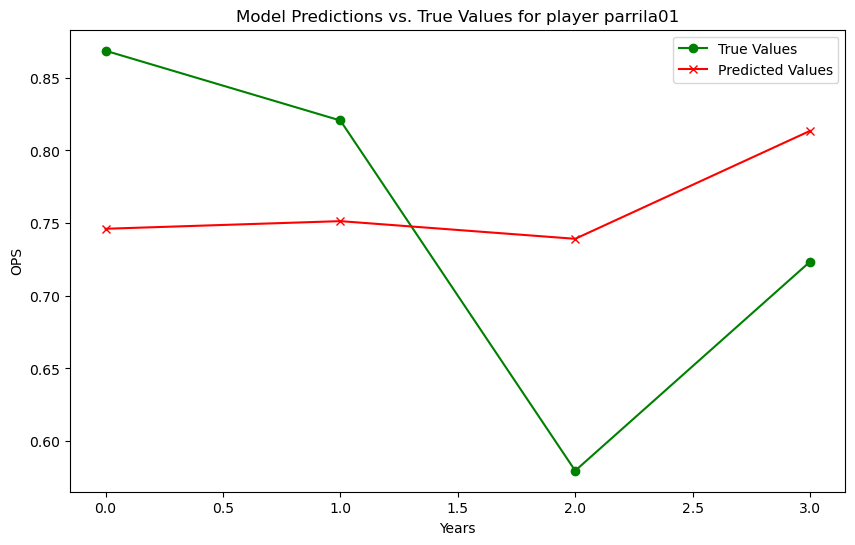

Showing predictions for player leonaje01


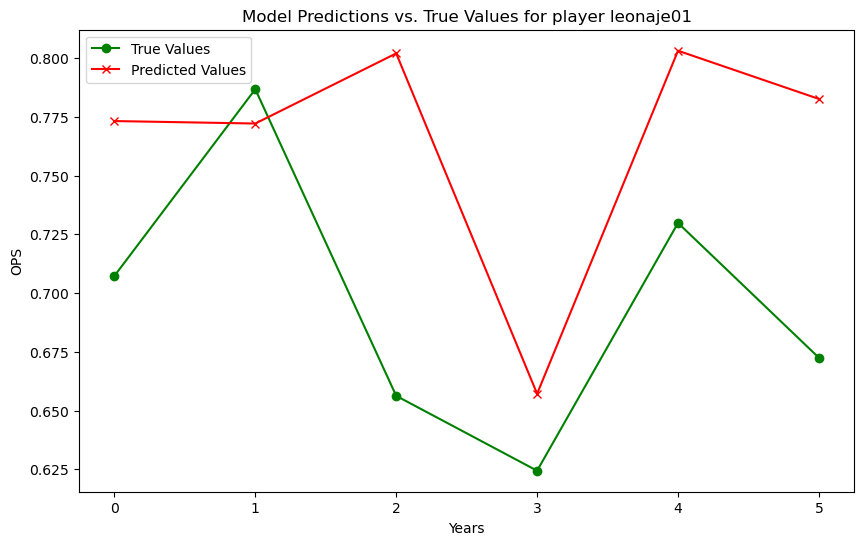

Showing predictions for player riceji01


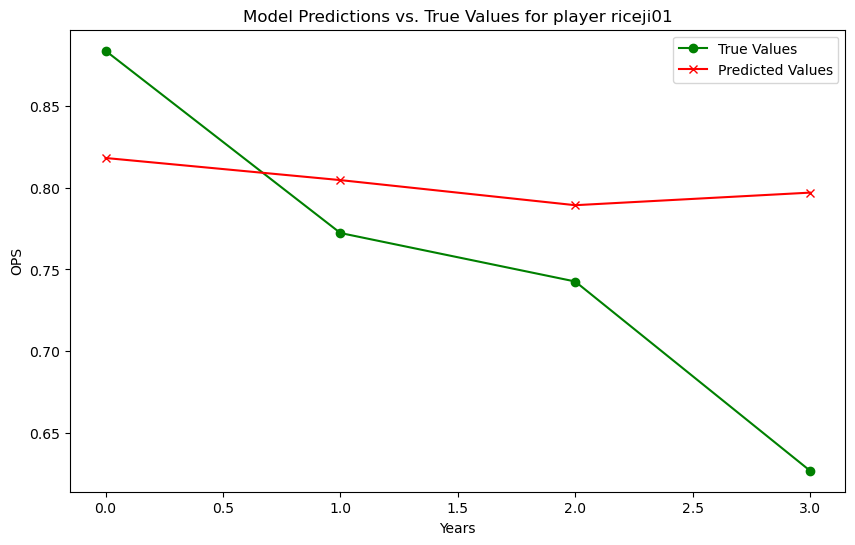

final test loss: 0.03023654595017433
Predictions on testing data
Showing predictions for player utleych01


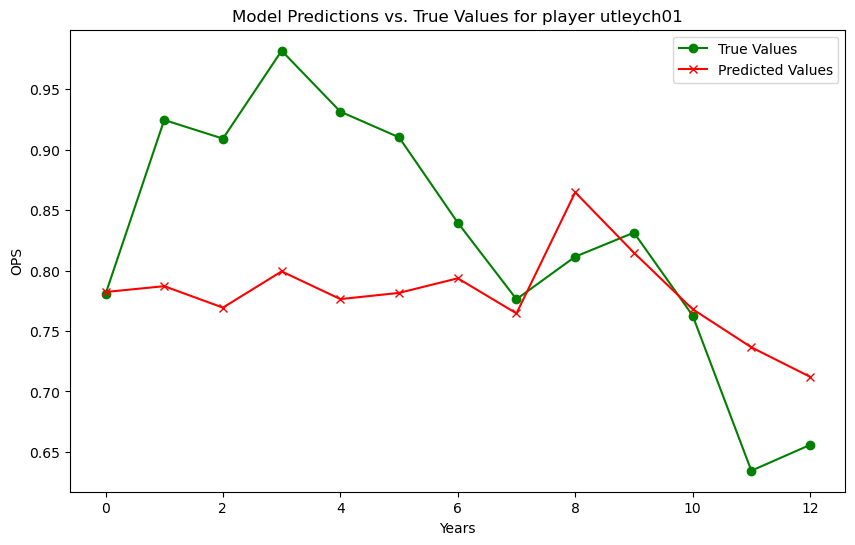

Showing predictions for player younger03


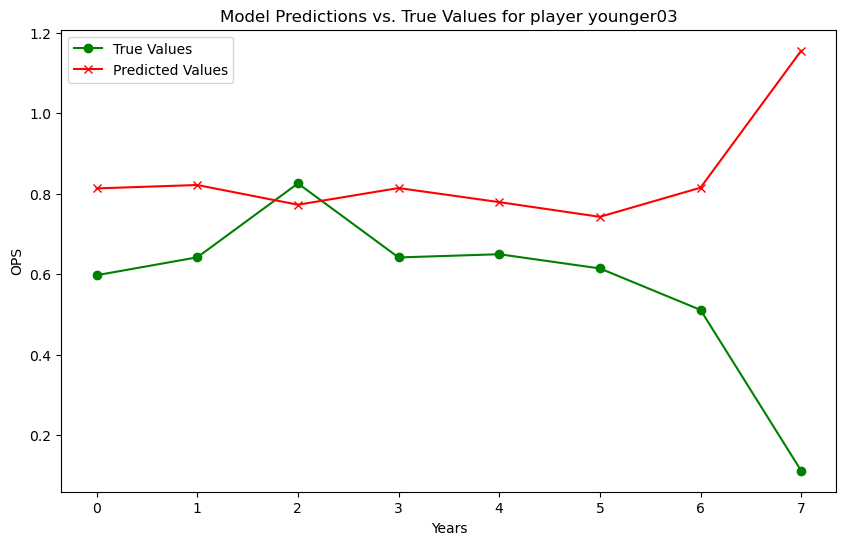

Showing predictions for player stewaia01


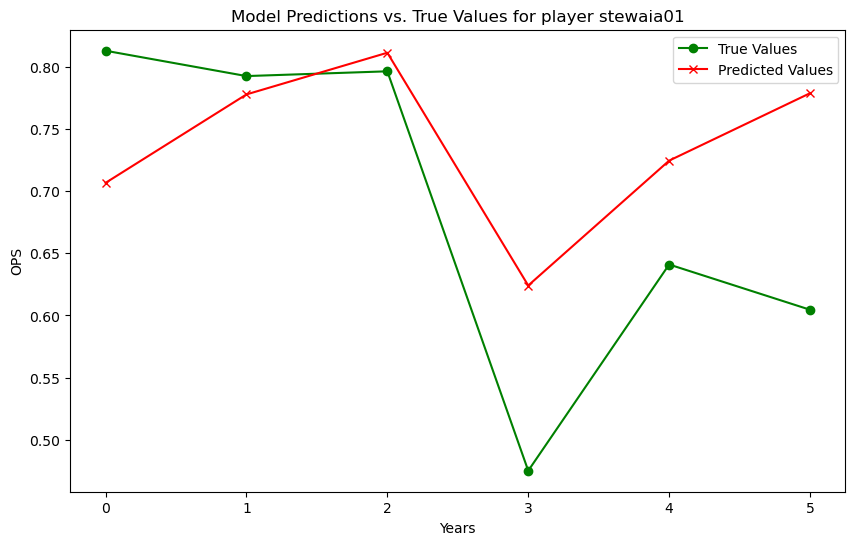

In [76]:
n_player_predictions_to_show = 3

print(f"final train loss: {train_loss}")
print("Predictions on training data")
plot_n_player_predictions(n_player_predictions_to_show, y_train, train_predictions, train_players, random=True)

test_players_temp = test_players.reset_index(inplace=False, drop=True)

print(f"final test loss: {test_loss}")
print("Predictions on testing data")
plot_n_player_predictions(n_player_predictions_to_show, y_test, test_predictions, test_players_temp, random=True)

In [77]:
torch.save(model.state_dict(), 'model_parameters.pth')


In [78]:

model = RNN_regresser(input_size, hidden_size, output_size, num_layers)  # Replace with your model's class
model.load_state_dict(torch.load('model_parameters.pth'))

<All keys matched successfully>